In [1]:
library(lubridate)
library(rugarch)

Loading required package: timechange


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [2]:
# Load returns
load("Y.RData")
y <- Y$AAPL
dates <- Y$date

# Parameters
portfolio_value = 1000
p = 0.05 #probability for VaR

In [3]:
# Function that creates a GARCH forecast

DoGARCH <- function(y, spec, probability = 0.05, portfolio_value = 1, WE = 1000){
    # GARCH function that takes as argument:
    # y: A vector of returns, ordered by date
    # spec: The ugarchspec object with the GARCH specification
    # probability: The probability to be used for VaR - Default 5%
    # portfolio_value: The portfolio value - Default 1
    # WE: Estimation window for the forecast - Default 1000 days
    
    # To calculate elapsed time, first get the current time
    old <- Sys.time()
    
    # Print message
    cat("Doing GARCH VaR forecast", "\n",
       "Estimation window:", WE, "\n",
       "Number of observations:", length(y), "\n",
       "VaR probability:", probability, "\n",
       "Portfolio value:", portfolio_value)
    
    # Number of observations
    n <- length(y)
    
    # Initialize empty VaR vector
    VaR <- rep(NA, n)
    
    # Do a loop for the forecast
    for (i in 1:(n-WE)){
        
        # Subset the dataset to the estimation window
        window <- y[i:(i+WE-1)]
        
        # Fit the GARCH
        res <- ugarchfit(spec = spec, data = window, solver = "hybrid")
        
        # Save coefficients
        omega <- coef(res)['omega']
        alpha <- coef(res)['alpha1']
        beta <- coef(res)['beta1']
        
        # Estimate sigma2 using the last observation of window
        sigma2 <- omega + alpha*tail(window,1)^2 + beta*tail(res@fit$var,1)
        
        # Allocate the VaR forecast in the vector
        VaR[i+WE] <- -sqrt(sigma2) * qnorm(probability) * portfolio_value
    }
    
    # Get the new time and print the elapsed time
    time <- difftime(Sys.time(), old, units = "secs")
    cat("\n", "Elapsed time:", round(time,4), "seconds")
    
    # Return the VaR vector
    return(VaR)
}

In [4]:
# Create specification
spec <- ugarchspec(
  variance.model = list(garchOrder= c(1,1)),
  mean.model = list(armaOrder = c(0,0), include.mean=FALSE)
)

In [5]:
# GARCH VaR for 300 days
GARCH300 <- DoGARCH(y, spec = spec, probability = 0.05, portfolio_value = 1000, WE = 300)

Doing GARCH VaR forecast 
 Estimation window: 300 
 Number of observations: 3083 
 VaR probability: 0.05 
 Portfolio value: 1000
 Elapsed time: 143.3586 seconds

In [6]:
# Saving the output
save(GARCH300, file = "GARCH300.RData")

In [7]:
# GARCH VaR for 1000 days
GARCH1000 <- DoGARCH(y, spec = spec, probability = 0.05, portfolio_value = 1000, WE = 1000)

Doing GARCH VaR forecast 
 Estimation window: 1000 
 Number of observations: 3083 
 VaR probability: 0.05 
 Portfolio value: 1000
 Elapsed time: 173.7879 seconds

In [8]:
# Saving the output
save(GARCH1000, file = "GARCH1000.RData")

In [9]:
# GARCH VaR for 2000 days
GARCH2000 <- DoGARCH(y, spec = spec, probability = 0.05, portfolio_value = 1000, WE = 2000)

Doing GARCH VaR forecast 
 Estimation window: 2000 
 Number of observations: 3083 
 VaR probability: 0.05 
 Portfolio value: 1000
 Elapsed time: 129.1353 seconds

In [10]:
# Saving the output
save(GARCH2000, file = "GARCH2000.RData")

In [11]:
# If we have it already saved, we can load it by:
load("GARCH300.RData")
load("GARCH1000.RData")
load("GARCH2000.RData")

Warning message in 1:2:3:
“numerical expression has 2 elements: only the first used”
Warning message in 1:2:3:
“numerical expression has 2 elements: only the first used”


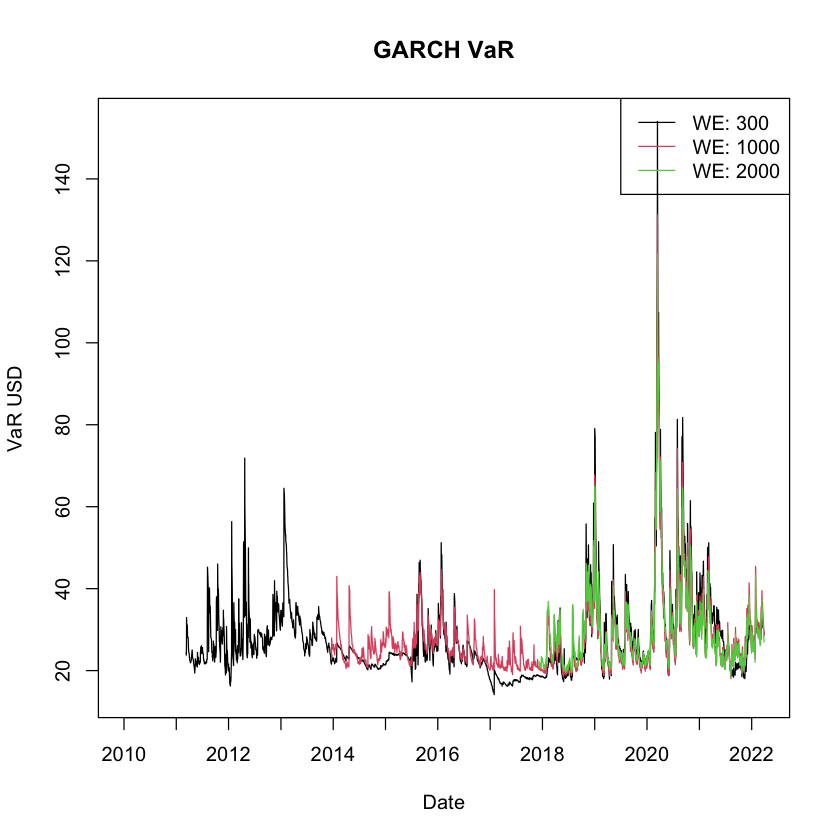

In [15]:
# Bind into a matrix
GARCH_VaR <- cbind(GARCH300, GARCH1000, GARCH2000)

# Plot and modify axis to include dates
matplot(dates, GARCH_VaR, type = "l", lty = 1, col = 1:2:3, xaxt = "n", main = "GARCH VaR", xlab = "Date", ylab = "VaR USD")
axis.Date(1, at = seq(min(dates), max(dates), by = "years"))

# Legend
legend("topright", legend = c("WE: 300","WE: 1000","WE: 2000"), lty = 1, col = 1:2:3)

In [16]:
# Combining all VaR forecasts
# VaR is load from .RData file includes VaR for HS300, HS1000, HS2000 and EWMA
VaR <- cbind(GARCH300, GARCH1000, GARCH2000)

In [17]:
# Means for each forecast
round(colMeans(VaR, na.rm = TRUE),3)

# Standard deviations - We
round(apply(VaR, MARGIN = 2, sd, na.rm = TRUE))

GARCH300 GARCH1000 GARCH2000 
   27.514    27.657    29.951

GARCH300 GARCH1000 GARCH2000 
       10         9        11

Warning message in 1:2:3:
“numerical expression has 2 elements: only the first used”
Warning message in 1:2:3:
“numerical expression has 2 elements: only the first used”


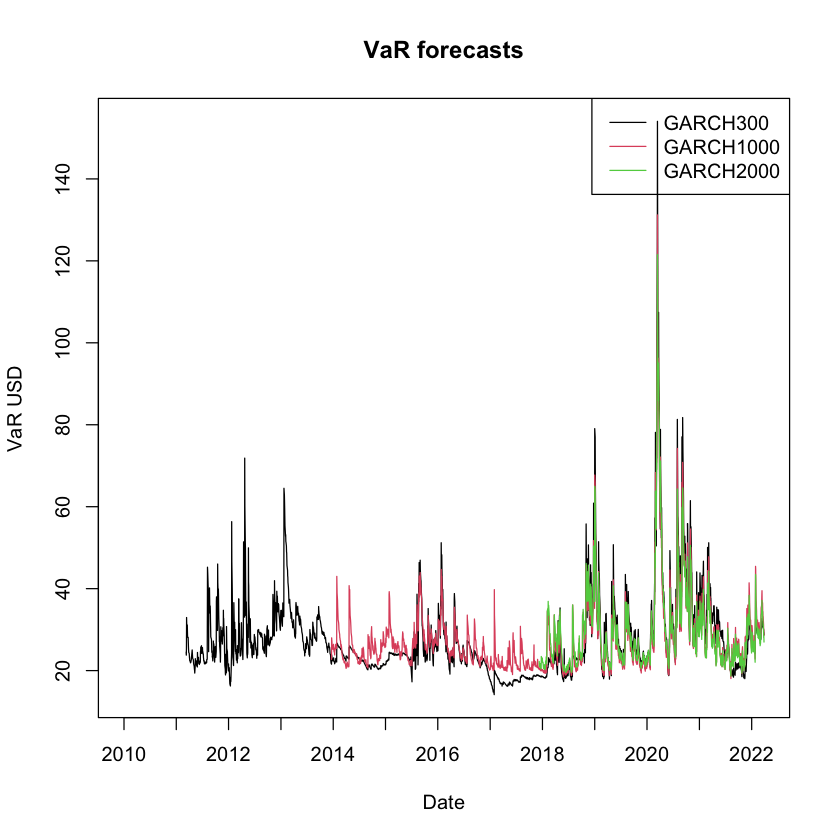

In [18]:
# Plot all
matplot(dates, VaR, type = "l", lty = 1, col = 1:2:3, xaxt = "n", main = "VaR forecasts", xlab = "Date", ylab = "VaR USD")
axis.Date(1, at = seq(min(dates), max(dates), by = "years"))

# Legend
legend("topright", legend = colnames(VaR), lty = 1, col = 1:2:3)

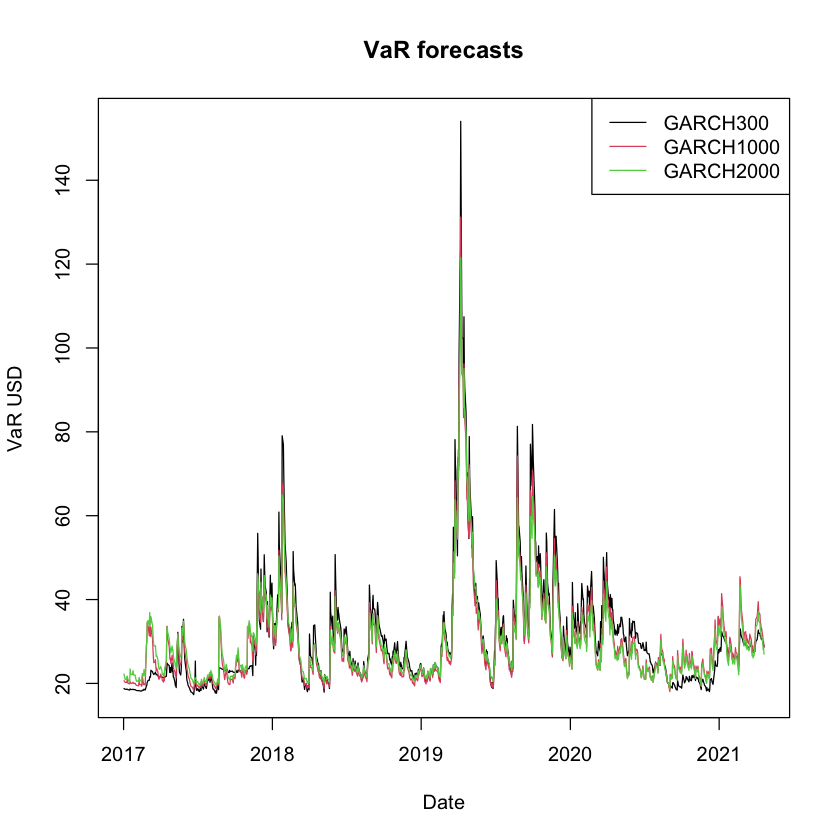

In [19]:
# Find maximum estimation window
windows <- colSums(is.na(VaR))

#restrict to largest estimation window
start <- max(windows) + 1
end <- length(dates)

# Plot all
matplot(dates[start:end], VaR[start:end,], type = "l", lty = 1, col = 1:6, xaxt = "n",
        main = "VaR forecasts", xlab = "Date", ylab = "VaR USD")
axis.Date(1, at = seq(dates[max(windows)], max(dates), by = "years"))

# Legend
legend("topright", legend = colnames(VaR), lty = 1, col = 1:6)